 ## Ames Iowa Housing - Regression & Classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
df_data = pd.read_csv('train.csv')
final_data = pd.read_csv('test.csv')

## EDA

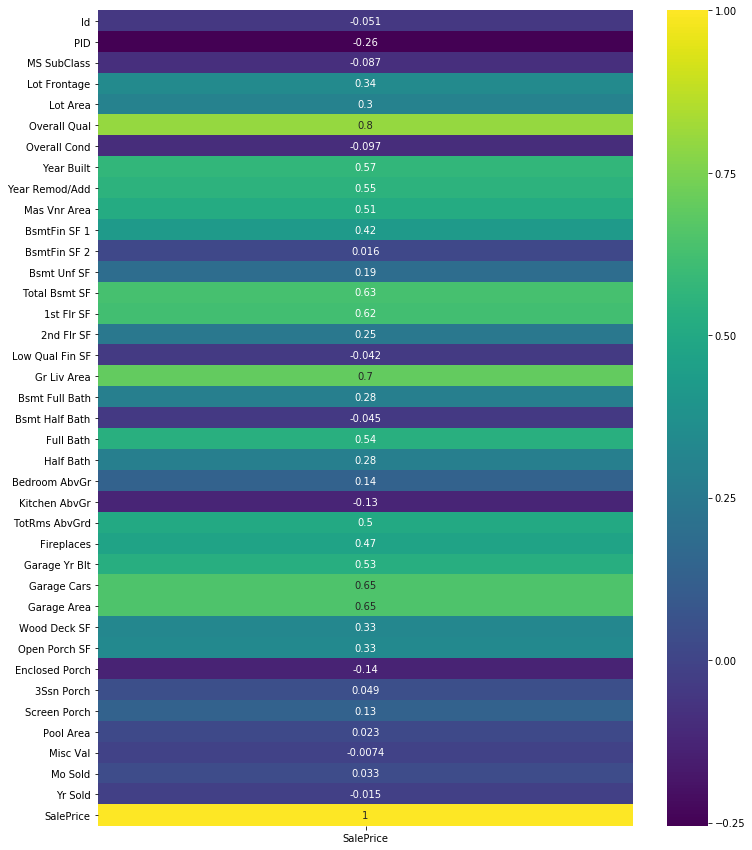

In [3]:
plt.figure(figsize=(12,15))
sns.heatmap(df_data.corr()[['SalePrice']], annot=True, cmap='viridis')

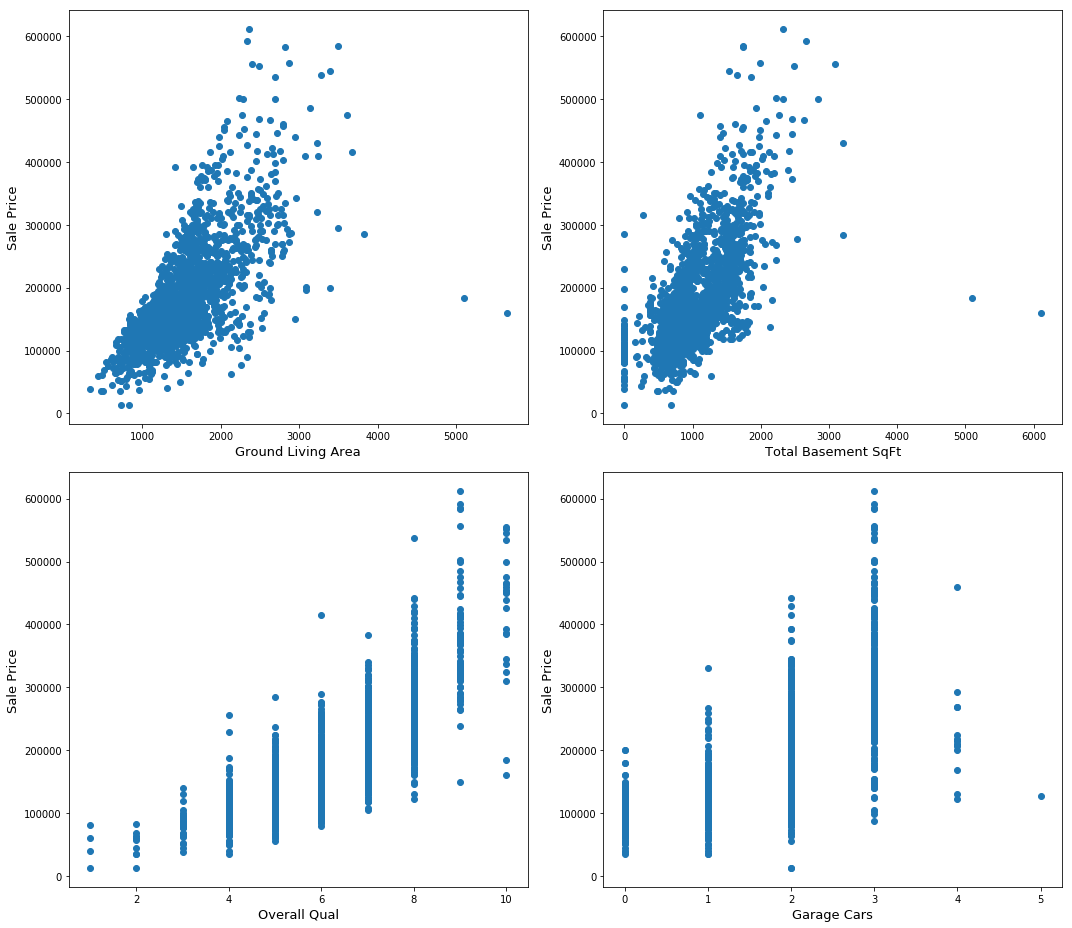

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 13))
ax[0,0].scatter(df_data['Gr Liv Area'], df_data['SalePrice'])
ax[0,1].scatter(df_data['Total Bsmt SF'], df_data['SalePrice'])
ax[1,0].scatter(df_data['Overall Qual'], df_data['SalePrice'])
ax[1,1].scatter(df_data['Garage Cars'], df_data['SalePrice'])

ax[0,0].set_ylabel('Sale Price', fontsize=13)
ax[0,0].set_xlabel('Ground Living Area', fontsize=13)

ax[0,1].set_ylabel('Sale Price', fontsize=13)
ax[0,1].set_xlabel('Total Basement SqFt', fontsize=13)

ax[1,0].set_ylabel('Sale Price', fontsize=13)
ax[1,0].set_xlabel('Overall Qual', fontsize=13)

ax[1,1].set_ylabel('Sale Price', fontsize=13)
ax[1,1].set_xlabel('Garage Cars', fontsize=13)

plt.tight_layout()
plt.show()

## Functions for Cleaning the Data

In [3]:
def does_does_not(cell):
    if cell >= 1:
        return 1
    else:
        return 0

def clean(df):
    # Clean column names
    df.rename(columns= {col: col.lower().replace(' ','_') for col in df.columns}, inplace=True)
    
    # Creation of a deck/porch column
    df['deck_porch'] = df['wood_deck_sf'] + df['open_porch_sf'] + df['enclosed_porch'] + df['3ssn_porch'] + df['screen_porch']
    
    # Setting fence to an interger
    df['fence'] = df['fence'].notnull().astype('int')

    # Dropping columns that are going to be covered by binary columns
    df.drop([
    'alley', 'lot_frontage', 'mas_vnr_type', 'fireplace_qu', 'pool_qc', 'misc_feature',
    'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2',
    'bsmtfin_sf_2', 'bsmt_unf_sf', 'bsmt_full_bath', 'bsmt_half_bath',
    'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_area', 'garage_qual', 'garage_cond',
    'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'
    ], axis=1, inplace=True)

    # Creation of binary columns
    features_replace = ['pool_area', 'fireplaces', 'mas_vnr_area', 'deck_porch']
    for i in features_replace:
        df[i] = df[i].map(does_does_not)

    # Renaming the binary columns
    df.rename(columns={
    'pool_area': 'has_pool',
    'fireplaces': 'has_fireplace',
    'mas_vnr_area': 'has_mas_vnr',
    'fence': 'has_fence'}, inplace=True)

    # Combining similar values
    df['lot_shape'] =df['lot_shape'].replace({'IR3':'IR2'})
    df['condition_1'] =df['condition_1'].replace({'PosA':'Pos', 'PosN':'Pos', 'RRAe':'RRe', 'RRNe':'RRe', 'RRNn':'RRn', 'RRAn':'RRn'})
    df['condition_2'] =df['condition_2'].replace({'PosA':'Pos', 'PosN':'Pos', 'RRAe':'RRe', 'RRNe':'RRe', 'RRNn':'RRn', 'RRAn':'RRn'})
    
    # Changing ordinal categorical values to numerical
    df['exter_qual'] = df['exter_qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['exter_cond'] = df['exter_cond'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['heating_qc'] = df['heating_qc'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
    df['electrical'] = df['electrical'].replace({'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1})
    df['kitchen_qual'] = df['kitchen_qual'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})

    # Dropping similar columns
    df.drop(['1st_flr_sf', '2nd_flr_sf', 'bedroom_abvgr'], axis=1, inplace=True)

    # Creation of dummy columns for catergorical columns
    df = pd.get_dummies(df, columns=[
    'neighborhood',
    'lot_shape',
    'ms_subclass',
    'ms_zoning',
    'land_contour',
    'lot_config',
    'utilities',
    'land_slope',
    'condition_1',
    'condition_2',
    'bldg_type',
    'exterior_1st',
    'exterior_2nd',
    'foundation',
    'heating',
    'central_air',
    'full_bath',
    'half_bath',
    'kitchen_abvgr',
    'functional',
    'paved_drive',
    'sale_type',
    'street',
    'house_style',
    'roof_style',
    'roof_matl',
    'electrical'
    ], prefix=[
    'n_',
    'ls_',
    'mssub_',
    'mszon_',
    'landcon_',
    'lotfig_',
    'ut_',
    'landm_',
    'cond1_',
    'cond2_',
    'btype_',
    'ext1_',
    'ext2_',
    'found_',
    'heat_',
    'ac_',
    'fb_',
    'hb_',
    'kita_',
    'funct_',
    'paved_',
    'stype_',
    'st_',
    'hstyle_',
    'rst_',
    'rmat_',
    'ele_'
    ])
    
    return df

def mia_columns(df1, df2):
    mia_df2 = list(set(df1.columns) - set(df2.columns))
    print(mia_df2)
    mia_df1 = list(set(df2.columns) - set(df1.columns))
    print(mia_df1)
    
    for i in mia_df2:
        df2[i] = 0
    
    for i in mia_df1:
        df2.drop([i], axis=1, inplace=True)
    
    # Filling null values with 0    
    for x in ['total_bsmt_sf', 'garage_cars']:
        df1[x].fillna(0, inplace=True)
        df2[x].fillna(0, inplace=True)

In [4]:
df = clean(df_data)
final = clean(final_data)

# Remvoing Outliers
df = df.loc[df['gr_liv_area'] < 4000].copy()

# Remove columns from our test data (final) that are not in our test data
mia_columns(df, final)

['ele__1', 'heat__OthW', 'mszon__A (agr)', 'funct__Sev', 'mssub__150', 'ut__NoSeWa', 'cond2__Artery', 'ele__3', 'rmat__Membran', 'cond2__RRn', 'ele__5', 'ele__2', 'n__GrnHill', 'ext2__Stone', 'sale_condition', 'funct__Sal', 'ext1__CBlock', 'ele__4', 'cond2__RRe', 'saleprice', 'heat__Wall', 'rmat__ClyTile', 'n__Landmrk', 'ext1__ImStucc', 'ext1__Stone']
['ele__2.0', 'stype__VWD', 'heat__Floor', 'ext2__Other', 'ext2__PreCast', 'ele__3.0', 'ext1__PreCast', 'ele__5.0', 'rmat__Metal', 'ele__4.0', 'rmat__Roll']


## Regression Modeling - Lasso

In [5]:
y = df['saleprice']
X = df.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', Lasso())
])

In [10]:
params = {
    'lasso__alpha': np.logspace(2,3,20),
}
gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lasso__alpha': array([  100.     ,   112.88379,   127.4275 ,   143.84499,   162.37767,
         183.29807,   206.91381,   233.57215,   263.66509,   297.63514,
         335.98183,   379.26902,   428.13324,   483.29302,   545.55948,
         615.84821,   695.1928 ,   784.75997,   885.86679,  1000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [11]:
print(gs.best_score_, gs.best_params_)

0.877307802827 {'lasso__alpha': 885.86679041008233}


In [98]:
X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1) # , 'SalePrice'
pred = gs.predict(X_final)

In [100]:
# final['SalePrice'] = pred
# final[['id','SalePrice']].to_csv('export_lasso3.csv', index=False)

## Regression Modeling - Gradient Boosting

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

In [8]:
pipe_gb = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingRegressor())
])

In [11]:
params_gb = {
    'gb__loss': ['ls', 'lad'],
    'gb__max_depth': np.arange(5, 10, 1),
    'gb__criterion': ['mse', 'mae', 'friedman_mse'],
    'gb__max_features': ['sqrt', 'log2'],
    'gb__n_estimators': [100, 200, 300]
}
gs = GridSearchCV(pipe_gb, param_grid=params_gb, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
          ...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gb__loss': ['ls', 'lad'], 'gb__max_depth': array([5, 6, 7, 8, 9]), 'gb__criterion': ['mse', 'mae', 'friedman_mse'], 'gb__max_features': ['sqrt', 'log2'], 'gb__n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [12]:
print(gs.best_score_, gs.best_params_)

0.909997509652 {'gb__criterion': 'mse', 'gb__loss': 'ls', 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__n_estimators': 200}


In [119]:
X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice', 'SalePrice'], axis=1)
pred = gs.predict(X_final)

In [121]:
final['SalePrice'] = pred
final[['id','SalePrice']].to_csv('export_gd.csv', index=False)

## Classification

In [5]:
# Mapping Abnormal to 1 and Not Abnormal to 0
df['sale_condition'] = df['sale_condition'].map(lambda x: 1 if x == 'Abnorml' else 0)

In [7]:
y = df['sale_condition']
X = df.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1)

In [8]:
# Baseline Accuracy = 93.5%
y.value_counts(normalize = True)

0    0.935578
1    0.064422
Name: sale_condition, dtype: float64

In [9]:
X_train, X_test, y_train, y_test= train_test_split(X, y)

In [13]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [15]:
params = {
    'knn__n_neighbors': np.arange(5, 10, 1),
    'knn__weights': ['uniform', 'distance']
}
gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': array([5, 6, 7, 8, 9]), 'knn__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [16]:
print(gs.best_score_, gs.best_params_)

0.943359375 {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}


In [18]:
X_final = final.drop(['id', 'pid', 'sale_condition', 'saleprice'], axis=1) # , 'Sale Condition'
pred = gs.predict(X_final)

In [ ]:
final['Sale Condition'] = pred
final[['id','Sale Condition']].to_csv('class_knn.csv', index=False)